## Introduction

In this notebook, we perform image classification on the CIFAR-10 dataset using a feature extraction approach applied to a pre-trained ResNet-18 model.

ResNet-18 is a deep convolutional neural network that introduced the concept of residual learning through skip connections. Residual connections help mitigate the vanishing gradient problem and allow much deeper networks to be trained effectively. ResNet-18 is a relatively lightweight version of the ResNet family and features 18 layers.

For this project:
- We load a ResNet-18 model pre-trained on the ImageNet dataset.
- We remove the original final fully connected layer.
- We extract features from the frozen ResNet-18.
- Initially, we considered using a pure linear probing approach (training only a single linear layer on top of the features).
- However, to improve performance, we instead train a small two-layer neural network (MLP) with a hidden layer and dropout regularization on top of the extracted features.

Training is performed using PyTorch, and model performance is evaluated based on both training and validation accuracy.

---

### Reference

He, Kaiming; Zhang, Xiangyu; Ren, Shaoqing; and Sun, Jian.  
*Deep Residual Learning for Image Recognition.*  
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016.


In [5]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Loading and Initialization

First, we load the ResNet-18 model pre-trained on the ImageNet dataset.

In [7]:
# Load ResNet-18 model with pre-trained ImageNet weights
weights = ResNet18_Weights.IMAGENET1K_V1
ResNet18 = resnet18(weights=weights)
ResNet18 = ResNet18.to(device)
summary(ResNet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Data Loading and Preprocessing

In this section, we prepare the CIFAR-10 dataset for input into the ResNet-18 model. Each image is resized from 32x32 pixels to 224x224 pixels to match the input size expected by ResNet-18. Normalization is applied using the mean and standard deviation values from ImageNet.

In [8]:
# The transformation pipeline for CIFAR-10 images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images from 32x32 to 224x224 (expected by ResNet-18)
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
        std=[0.229, 0.224, 0.225]    # Normalize using ImageNet standard deviation
    )
])

# ------------------------------------------
# CIFAR-10 Dataset and DataLoaders
# ------------------------------------------

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,                  # Shuffle training data to improve generalization
    num_workers=os.cpu_count(),
    pin_memory=True
)

# Create a DataLoader for the test set
testloader = DataLoader(
    testset,
    batch_size=64,
    shuffle=False,                  # No need to shuffle test data
    num_workers=os.cpu_count(),
    pin_memory=True
)


100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


## Feature Extraction

To perform linear probing, we first extract high-level feature representations from the pre-trained ResNet-18 model. We remove the final fully connected classification layer from ResNet-18. The remaining network (up to the global average pooling layer) is used as a fixed feature extractor. We next pass both the training and test sets through the feature extractor. The final feature maps are flattened to shape (batch_size, 512).


In [9]:
# Create a feature extractor by removing the final fully connected (classification) layer from ResNet-18
feature_extractor = nn.Sequential(*list(ResNet18.children())[:-1])  # Keep all layers except the last FC layer
feature_extractor.eval()
feature_extractor.to(device)

train_features = []
train_labels = []

# Extract features for the training dataset
with torch.no_grad():
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        features = feature_extractor(images)             # Output shape: (batch_size, 512, 1, 1)
        features = features.view(features.size(0), -1)   # Flatten to shape: (batch_size, 512)
        train_features.append(features.cpu())
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)

test_features = []
test_labels = []

# Extract features for the test dataset
with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        features = feature_extractor(images)             # Output shape: (batch_size, 512, 1, 1)
        features = features.view(features.size(0), -1)   # Flatten to shape: (batch_size, 512)
        test_features.append(features.cpu())
        test_labels.append(labels)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 157/157 [00:18<00:00,  8.32it/s]


## Training a Two-Layer Neural Network on ResNet-18 Features

In this section, we train a small feed-forward neural network on top of the extracted feature representations from ResNet-18.
Originally, we considered using a simple linear probing approach (training only a single linear layer). However, to achieve better classification performance, we instead used a two-layer multilayer perceptron (MLP) with dropout regularization.

The classifier architecture consists of:
- An input layer of 512 dimensions.
- A hidden layer reducing to 256 dimensions, followed by ReLU activation.
- Dropout layers applied before and after the hidden layer to improve generalization.
- A final linear layer mapping the hidden representation to 10 CIFAR-10 output classes.

The training setup is as follows:
- **Optimizer**: Adam with an initial learning rate of 0.001.
- **Learning rate scheduler**: Exponential decay with a factor of 0.9 applied after each epoch.
- **Loss function**: Cross-entropy loss for multi-class classification.



In [10]:
# Number of training epochs
epochs = 75

train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Define a simple linear classifier on top of 512-dim ResNet-18 features
# We also add a small MLP with Dropout for regularization
classifier = nn.Sequential(
    nn.Dropout(0.25),          # Dropout layer (25%)
    nn.Linear(512, 256),        # Linear layer: 512 -> 256
    nn.ReLU(),                 # ReLU activation
    nn.Dropout(0.25),           # Another Dropout layer (25%)
    nn.Linear(256, 10)          # Final linear layer: 256 -> 10 CIFAR-10 classes
).to(device)

# The optimizer (Adam) and learning rate scheduler (Exponential decay)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# The loss function: cross-entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Train over entire training dataset
    for features, labels in trainloader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    # Compute average training loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_acc.append(100 * correct / total)

    # Step the learning rate scheduler
    scheduler.step()

    classifier.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    # Test over entire test dataset
    with torch.no_grad():
        for features, labels in testloader:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)

    # Compute average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(testloader)
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_acc.append(test_accuracy)

print("\n=== Final Results After Training ===")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Test Loss: {test_losses[-1]:.4f}")
print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")



=== Final Results After Training ===
Final Training Loss: 0.3526
Final Training Accuracy: 87.27%
Final Test Loss: 0.3535
Final Test Accuracy: 88.24%


## Conclusion

After training a small two-layer neural network (MLP) on the extracted ResNet-18 feature representations for 75 epochs, the final results are summarized below:

| Metric                  | Value          |
|--------------------------|----------------|
| Final Training Loss      | 0.3526          |
| Final Training Accuracy  | 87.27%          |
| Final Test Loss          | 0.3535          |
| Final Test Accuracy      | 88.24%          |

Initially, a pure linear probing approach was considered. However, to achieve better performance, a two-layer neural network with a hidden layer and dropout regularization was trained instead. Using this architecture, we achieved test accuracy of **88.24%**, with a small gap between training and validation performance.



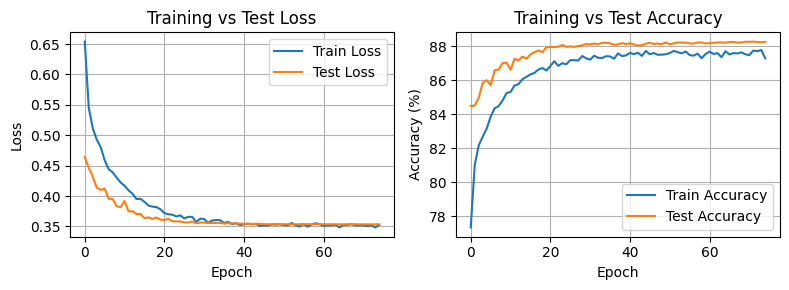

In [11]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
